# `tfplot.contrib`: Some pre-defined plot ops

The `tfplot.contrib` package contains some off-the-shelf functions for defining plotting operations.
This package provides some off-the-shelf functions that could be useful widely across many typical use cases.

Unfortunately, it may not provide super flexible and fine-grained customization points beyond the current parameters. If it does not fit what you want to get, then consider designing your own plotting functions using `tfplot.autowrap`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams, rc
from IPython.core.pylabtools import figsize
figsize(5, 4)

%config InlineBackend.figure_format = 'retina'

## Setup (Skip this!)

In [3]:
import numpy as np
import tensorflow as tf

sess = tf.InteractiveSession()

In [4]:
from PIL import Image
def execute_op_as_image(op):
    """
    Evaluate the given `op` and return the content PNG image as `PIL.Image`.
    
    - If op is a plot op (e.g. RGBA Tensor) the image or
      a list of images will be returned
    - If op is summary proto (i.e. `op` was a summary op),
      the image content will be extracted from the proto object.
    """
    print ("Executing: " + str(op))
    ret = sess.run(op)
    plt.close()

    if isinstance(ret, np.ndarray):
        if len(ret.shape) == 3:
            # single image
            return Image.fromarray(ret)
        elif len(ret.shape) == 4:
            return [Image.fromarray(r) for r in ret]
        else:
            raise ValueError("Invalid rank : %d" % len(ret.shape))            
            
    elif isinstance(ret, (str, bytes)):
        from io import BytesIO
        s = tf.Summary()
        s.ParseFromString(ret)
        ims = []
        for i in range(len(s.value)):
            png_string = s.value[i].image.encoded_image_string
            im = Image.open(BytesIO(png_string))
            ims.append(im)
        plt.close()
        if len(ims) == 1: return ims[0]
        else: return ims
        
    else:
        raise TypeError("Unknown type: " + str(ret))

In [5]:
def fake_attention():
    import scipy.ndimage
    attention = np.zeros([16, 16], dtype=np.float32)
    attention[(11, 8)] = 1.0
    attention[(9, 9)] = 1.0
    attention = scipy.ndimage.filters.gaussian_filter(attention, sigma=1.5)
    return attention

import scipy
sample_image = scipy.misc.face()
attention_map = fake_attention()

In [6]:
import tfplot.contrib

for fn in sorted(tfplot.contrib.__all__):
    print("%-20s" % fn, tfplot.contrib.__dict__[fn].__doc__.split('\n')[1].strip())

batch                Make an autowrapped plot function (... -> RGBA tf.Tensor) work in a batch
probmap              Display a heatmap in color. The resulting op will be a RGBA image Tensor.
probmap_simple       Display a heatmap in color, but only displays the image content.


## probmap

For example, `probmap` and `probmap_simple` create an image Tensor that visualizes a probability map:

Tensor("attention_op:0", shape=(16, 16), dtype=float32)
Executing: Tensor("probmap:0", shape=(?, ?, 4), dtype=uint8)


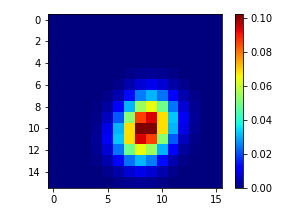

In [7]:
attention_op = tf.constant(attention_map, name="attention_op")
print(attention_op)

op = tfplot.contrib.probmap(attention_map, figsize=(4, 3))
execute_op_as_image(op)

Executing: Tensor("probmap_1:0", shape=(?, ?, 4), dtype=uint8)


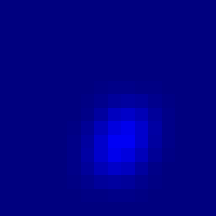

In [8]:
op = tfplot.contrib.probmap_simple(attention_map, figsize=(3, 3),
                                   vmin=0, vmax=1)
execute_op_as_image(op)

## Auto-batch mode (`tfplot.contrib.batch`)

In many cases, we may want to make plotting operations behave in a batch manner. You can use `tfplot.contrib.batch` to make those functions work in a batch mode:

Tensor("batch_tensor:0", shape=(5, 5, 5), dtype=float64)
Executing: Tensor("probmap_2/PlotImages:0", shape=(5, ?, ?, 4), dtype=uint8)


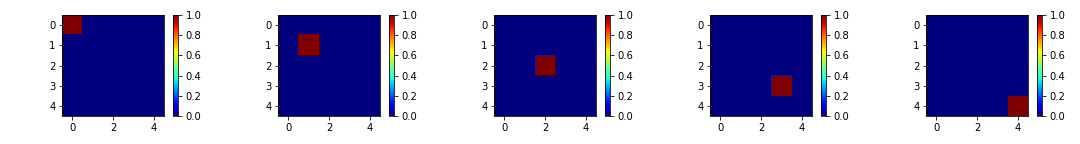

In [9]:
# batch version
N = 5
p = np.zeros([N, N, N])
for i in range(N):
    p[i, i, i] = 1.0

p = tf.constant(p, name="batch_tensor"); print(p)                      # (batch_size, 5, 5)
op = tfplot.contrib.batch(tfplot.contrib.probmap)(p, figsize=(3, 2))   # (batch_size, H, W, 4)

results = execute_op_as_image(op)      # list of N images
Image.fromarray(np.hstack([np.asarray(im) for im in results]))